# Naive Classifier for Fake news recognition

In [2]:
source('naive_bayes.R') # load the proper functions to perform the computations

In [3]:
numCores <- detectCores() # for the parallel execution of code later on

# Reading the data and deciding what to analyze
We decide which dataset to analyze based on the variable `dataset`.
- `1` corresponds to `archive` dataset
- `2` corresponds to `archive` dataset, but with categorical destinction
- `3` corresponds to `fake-news` dataset
- `4` corresponds to `fake-news` dataset, but focusing on titles

In [4]:
dataset <- 3

In [5]:
# possible paths for the 2 datasets

train1.filename <- "dataset/archive/train.csv"
test1.filename <- "dataset/archive/test.csv"

train2.filename <- "dataset/fake-news/train.csv"
test2.filename <- "dataset/fake-news/test.csv"

In [7]:
# a simple if statement to normalize the dataset to use giving the proper names
# to the columns to be used by the algorithm; it also initializes the
# tags_numers object to keep track of labels names, numbers and colors for
# plotting
if (dataset == 1) {
    train.df <- read.delim(train1.filename, sep = ",")
    test.df <- read.delim(test1.filename, sep = ",")

    tags_numbers <- list(tags = c("Barely True", "False", "Half-True", "Mostly-True",
        "Not known", "True"), numbers = c(0:5), colors = c("#FF6666", "#FF9966",
        "#FFCC66", "#99FF99", "#CCCCCC", "#00FF99"))

} else if (dataset == 2) {
    train.df <- read.delim(train1.filename, sep = ",")
    test.df <- read.delim(test1.filename, sep = ",")

    train.df %>%
        filter(grepl("economy", Text_Tag)) %>%
        filter(!grepl("health-care", Text_Tag)) %>%
        filter(!grepl("taxes", Text_Tag)) %>%
        mutate(Labels = 0) -> economy

    train.df %>%
        filter(!grepl("economy", Text_Tag)) %>%
        filter(grepl("health-care", Text_Tag)) %>%
        filter(!grepl("taxes", Text_Tag)) %>%
        mutate(Labels = 1) -> health_care

    train.df %>%
        filter(!grepl("economy", Text_Tag)) %>%
        filter(!grepl("health-care", Text_Tag)) %>%
        filter(grepl("taxes", Text_Tag)) %>%
        mutate(Labels = 2) -> taxes

    train.df <- rbind(economy, health_care, taxes)

    test.df %>%
        filter(grepl("economy", Text_Tag)) %>%
        filter(!grepl("health-care", Text_Tag)) %>%
        filter(!grepl("taxes", Text_Tag)) %>%
        mutate(Labels = 0) -> economy_test

    test.df %>%
        filter(!grepl("economy", Text_Tag)) %>%
        filter(grepl("health-care", Text_Tag)) %>%
        filter(!grepl("taxes", Text_Tag)) %>%
        mutate(Labels = 1) -> health_care_test

    test.df %>%
        filter(!grepl("economy", Text_Tag)) %>%
        filter(!grepl("health-care", Text_Tag)) %>%
        filter(grepl("taxes", Text_Tag)) %>%
        mutate(Labels = 2) -> taxes_test

    test.df <- rbind(economy_test, health_care_test, taxes_test)

    tags_numbers <- list(tags = c("Economy", "Health-Care", "Taxes"), numbers = c(0:2),
        colors = c("#32D2FC", "#FCEA19", "#FF0759"))

} else if (dataset == 3) {
    train.df <- read.delim(train2.filename, sep = ",")
    test.df <- read.delim(test2.filename, sep = ",")

    train.df %>%
        filter(!text == "") %>%
        select(label, text) %>%
        rename(Labels = label, Text = text) -> train.df

    test.df %>%
        filter(!text == "") %>%
        select(text) %>%
        rename(Text = text) -> test.df

    tags_numbers <- list(tags = c("Reliable", "Unreliable"), numbers = c(0:1), colors = c("#36B1FF",
        "#EF8D00"))

} else if (dataset == 4) {
    train.df <- read.delim(train2.filename, sep = ",")
    test.df <- read.delim(test2.filename, sep = ",")

    train.df %>%
        filter(!title == "") %>%
        select(label, title) %>%
        rename(Labels = label, Text = title) -> train.df

    test.df %>%
        filter(!title == "") %>%
        select(title) %>%
        rename(Text = title) -> test.df

    tags_numbers <- list(tags = c("Reliable Title", "Unreliable Title"), numbers = c(0:1),
        colors = c("#36B1FF", "#EF8D00"))
}

# Display the train dataset
This is done in order to check the dataset schema.

`test.df` does not have the assigned Labels. We therefore are going to split the training dataset in actual training and validation sets to check the accuracy of the algorithm. 

In [8]:
head(train.df)

Labels
1 1     
2 0     
3 1     
4 1     
5 1     
6 0     
  Text                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [9]:
head(test.df)

Text                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

# Splitting the dataset into train and validation
This is the standard procedure to assess the accuracy of any algorithm running on data

In [10]:
set.seed(29062023) # seed for code reproducibility
train.df=train.df[sample(1:nrow(train.df), replace = F),] # shuffle the dataset

In [11]:
# set splitting percentages
perc_split <- 0.8  # 80% of original dataset is for training and 20% for validation
n_rows <- nrow(train.df)
n_rows_train <- floor(n_rows * perc_split)

# splitting
train.df.train <- train.df[1:n_rows_train, ] # takes the first n_rows
train.df.validation <- train.df[-c(1:n_rows_train), ] # takes the remaining rows

In [12]:
# show the splitted datasets number of rows
cat("Total rows:", nrow(train.df),
    "\nTrain rows:", nrow(train.df.train),
    "\nValidation rows", nrow(train.df.validation))

Total rows: 20761 
Train rows: 16608 
Validation rows 4153

# Labels distribution and prior definition
This is a necessary step in oder to check the distribution of the labels, and therefore compute the associated prior probabilities.

In [13]:
counts_labels <- table(train.df.train$Labels)  # count each label

In [14]:
n_classes <- length(counts_labels)  # count the number of different labels

## Defining the prior of each class

In [15]:
prior.classes <- counts_labels/sum(counts_labels)  # compute the prior for each kind of label

## Show the label distribution in a barplot

In [16]:
labels <- tags_numbers$tags
colors <- tags_numbers$colors

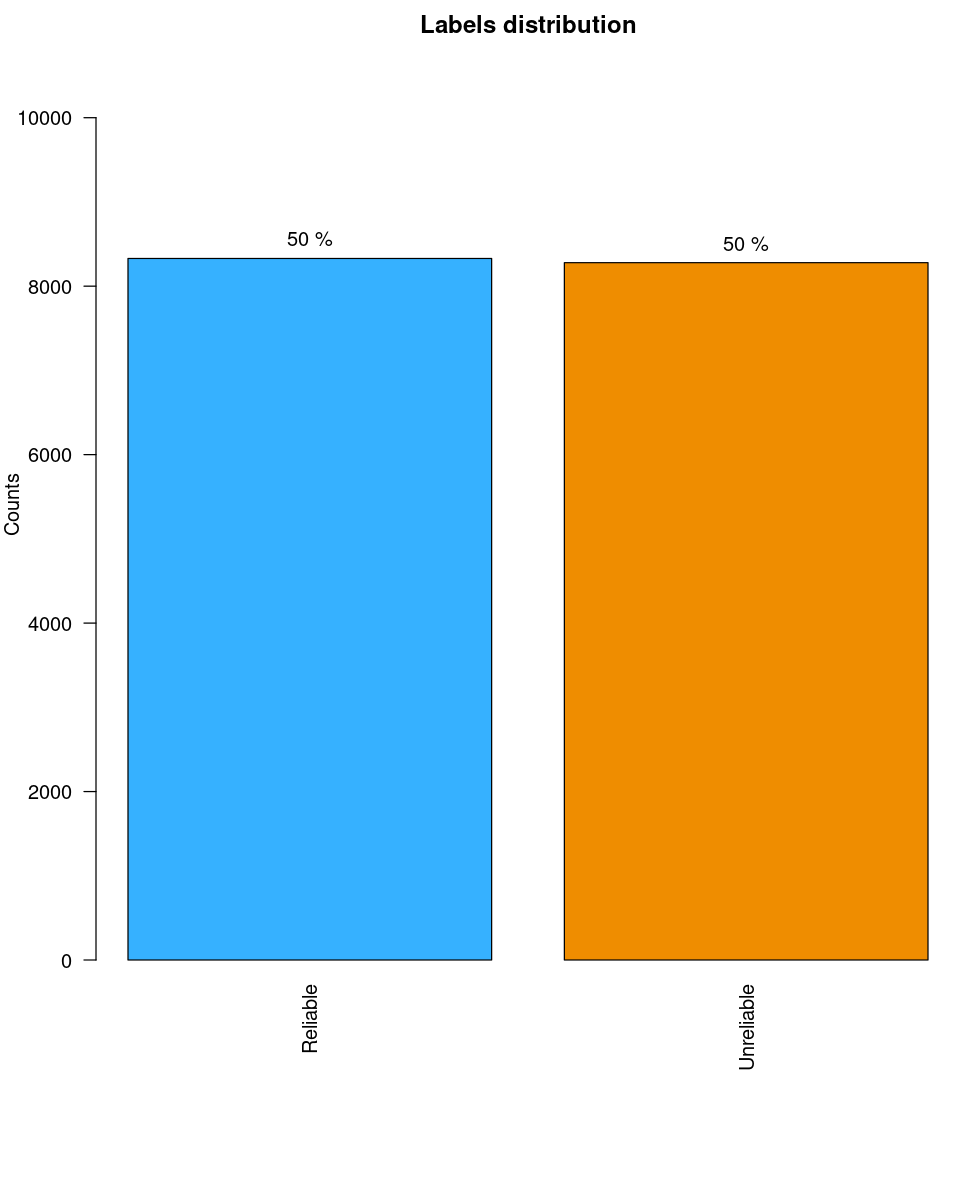

In [17]:
options(repr.plot.height = 10, repr.plot.width =8)

par(mar = c(10, 4, 2, 0))
b <- barplot(counts_labels, col = colors, names = labels, las = 2, ylab = "Counts",
    main = "Labels distribution", ylim = c(0, 1.3 * max(counts_labels)))
text(x = b, y = counts_labels, pos = 3, label = paste(round(prior.classes * 100,
    0), "%"), cex = 1)

# Stop words: those to be ignored
We decided to use the `tidytext` library which already implements a list of the most common stop words in English as shown below. All these words will be removed from the vocabulary when performing the Naive Bayes computations. 

In [18]:
as.list(get_stopwords())$word

[1] "i"          "me"         "my"         "myself"     "we"        
  [6] "our"        "ours"       "ourselves"  "you"        "your"      
 [11] "yours"      "yourself"   "yourselves" "he"         "him"       
 [16] "his"        "himself"    "she"        "her"        "hers"      
 [21] "herself"    "it"         "its"        "itself"     "they"      
 [26] "them"       "their"      "theirs"     "themselves" "what"      
 [31] "which"      "who"        "whom"       "this"       "that"      
 [36] "these"      "those"      "am"         "is"         "are"       
 [41] "was"        "were"       "be"         "been"       "being"     
 [46] "have"       "has"        "had"        "having"     "do"        
 [51] "does"       "did"        "doing"      "would"      "should"    
 [56] "could"      "ought"      "i'm"        "you're"     "he's"      
 [61] "she's"      "it's"       "we're"      "they're"    "i've"      
 [66] "you've"     "we've"      "they've"    "i'd"        "you'd"     
 [71] "he'd"       "she'd"      "we'd"       "they'd"     "i'll"      
 [76] "you'll"     "he'll"      "she'll"     "we'll"      "they'll"   
 [81] "isn't"      "aren't"     "wasn't"     "weren't"    "hasn't"    
 [86] "haven't"    "hadn't"     "doesn't"    "don't"      "didn't"    
 [91] "won't"      "wouldn't"   "shan't"     "shouldn't"  "can't"     
 [96] "cannot"     "couldn't"   "mustn't"    "let's"      "that's"    
[101] "who's"      "what's"     "here's"     "there's"    "when's"    
[106] "where's"    "why's"      "how's"      "a"          "an"        
[111] "the"        "and"        "but"        "if"         "or"        
[116] "because"    "as"         "until"      "while"      "of"        
[121] "at"         "by"         "for"        "with"       "about"     
[126] "against"    "between"    "into"       "through"    "during"    
[131] "before"     "after"      "above"      "below"      "to"        
[136] "from"       "up"         "down"       "in"         "out"       
[141] "on"         "off"        "over"       "under"      "again"     
[146] "further"    "then"       "once"       "here"       "there"     
[151] "when"       "where"      "why"        "how"        "all"       
[156] "any"        "both"       "each"       "few"        "more"      
[161] "most"       "other"      "some"       "such"       "no"        
[166] "nor"        "not"        "only"       "own"        "same"      
[171] "so"         "than"       "too"        "very"       "will"

# Example on prediction with data
Here is the code to be run in order to classify the messages.

We are showing only the fastest method to classify the messages: the feature selection based on the frequency.
Other feature selection methods were used, but they require more time to be run. They are compared below.

In [19]:
# get the countings for all the words
counts <- vocabulary(train.df.train, tags_numbers)

# vocabulary optimized with feature selection (other methods are discussed below)
naive.bayes.vocabulary <- feature_selection.frequency_mean(counts, n_classes, frac = 0.7)

# compute denominator of likelihood (for optimization issues, this is done outside other functions)
denominator <- likelihood.denominator(naive.bayes.vocabulary)

# compute the likelihood dataframe for each tokenized and unique word
likelihood.token <- likelihood(naive.bayes.vocabulary, denominator)

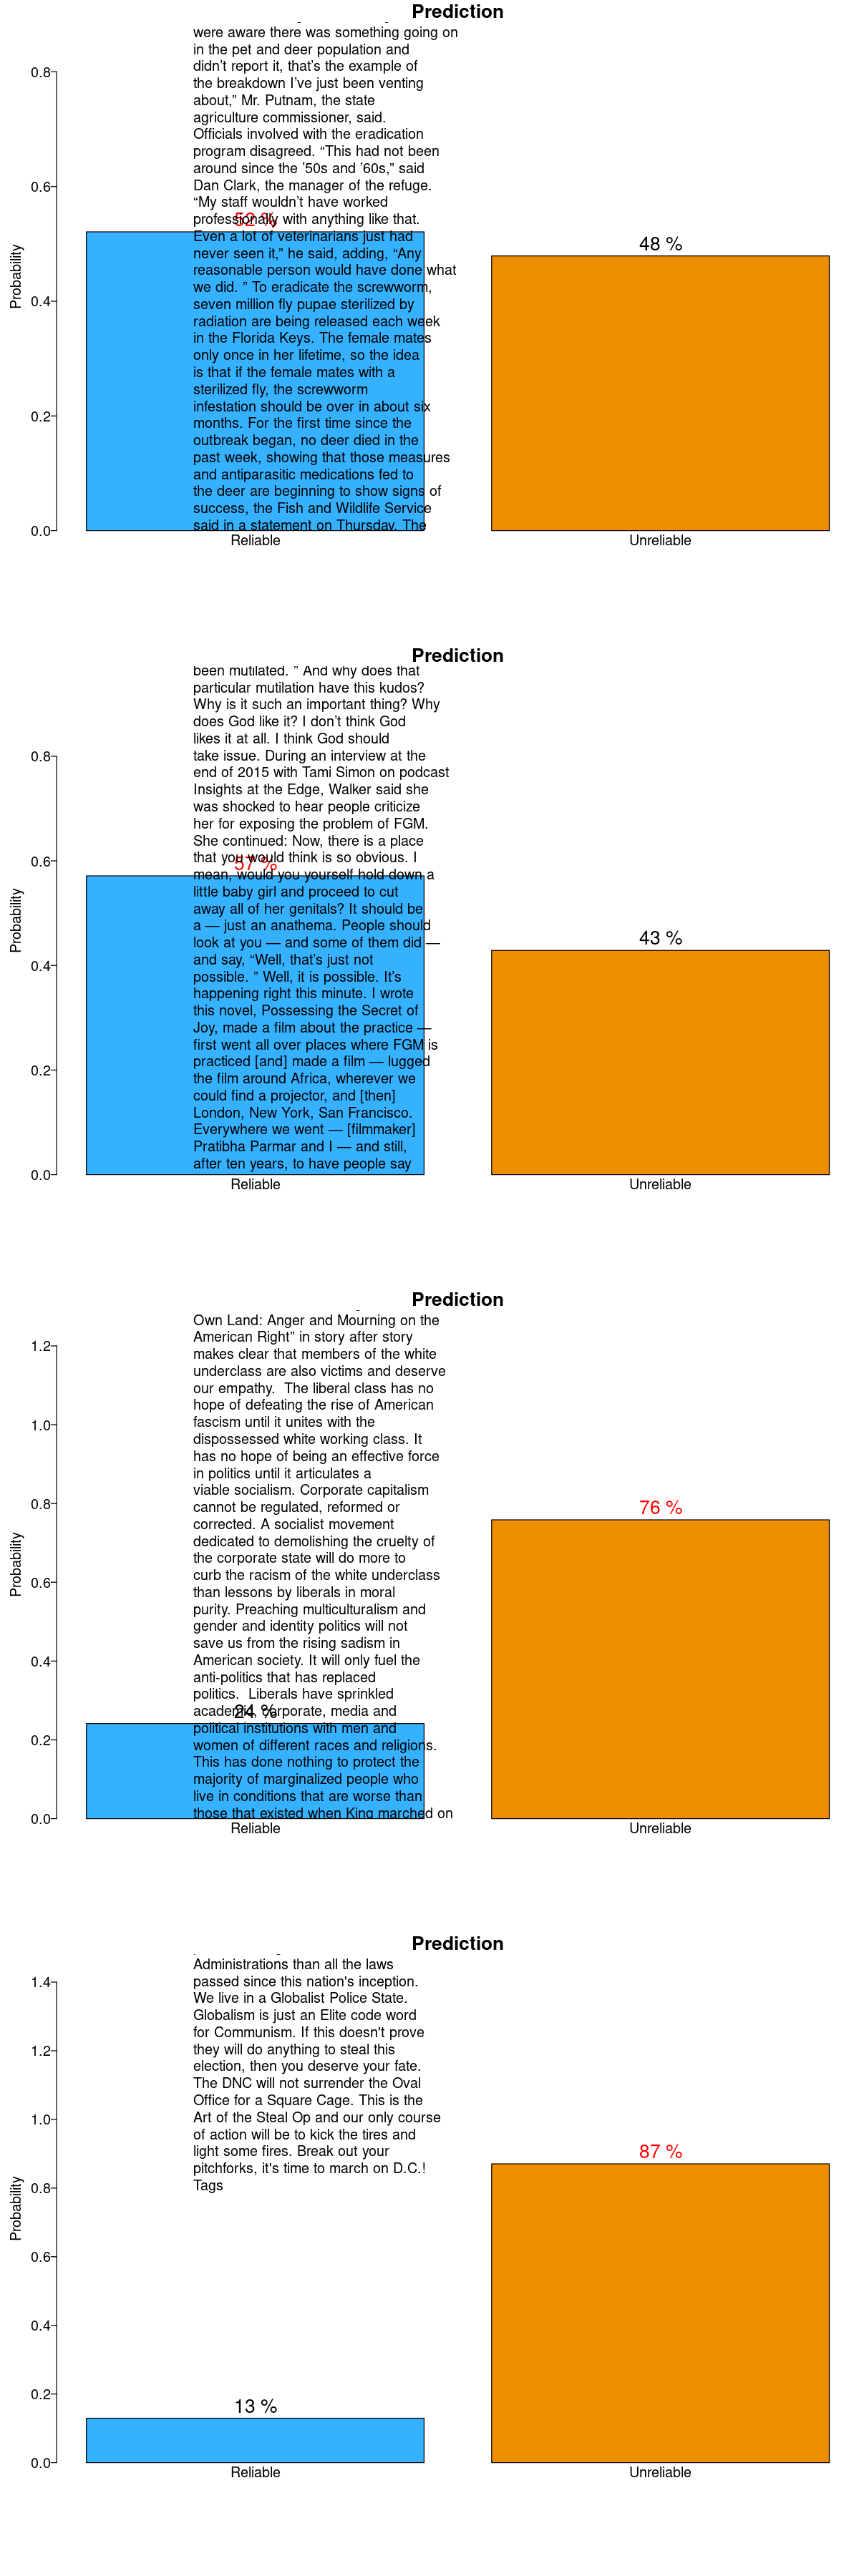

In [20]:
# plotting configurations
options(repr.plot.height = 30, repr.plot.width = 10)
par(mar = c(10, 5, 2, 0), mgp = c(3, 0.5, 0), mfrow = c(4, 1), cex.axis = 1.5, cex.lab = 1.4,
    cex.main = 2)

# show 4 examples
for (i in 1:4) {

    # get the text of the message from the test dataset
    msg<-test.df$Text[runif(n = 1, min = 1, max = nrow(test.df))]

    # tokenize single message
    token.list <- as.vector(tweet_tokenize(msg))

    # compute the posterior of being in each class
    probability <- bayes.probability(token.list, likelihood.token, prior.classes,
        denominator, n_classes)

    # get the predicted label, according to the max probability index
    predicted.label <- which.max(probability)

    # plot the probabilities for each class
    b <- barplot(probability, col = colors, names = labels, las = 1, ylab = "Probability",
        main = paste("Prediction"), ylim = c(0, 1.7 * max(probability)), cex.lab = 1.5)
    
    text(x = b, y = probability, pos = 3, label = paste(round(probability * 100,
        0), "%"), cex = 2, col = c(rep("black", predicted.label - 1), "red", rep("black",
        n_classes - predicted.label)))
    
    text(x = 0.5, y = 1.7 * max(probability) * 0.8, labels = paste(strwrap(msg, width = 40),
        collapse = "\n"), cex = 1.5, pos = 4)
}

To evaluate the performances of the naive Bayes algorithm, we run it with the validation dataset, keeping count of how many guesses are correct.

In [21]:
# run the prediction in parallel
predicted_classes <- mclapply(X = train.df.validation$Text, FUN = naive.bayes,
                              likelihood.token = likelihood.token,
                              prior.classes = prior.classes, den = denominator, 
                              n_classes = n_classes, mc.cores = numCores)

# Check % of right predictions
accuracy <- sum(predicted_classes == train.df.validation$Labels)/length(train.df.validation$Labels)

Warning message in mclapply(X = train.df.validation$Text, FUN = naive.bayes, likelihood.token = likelihood.token, :
“i core pianificati 3, 5, 2, 1, 6, 8, 7 hanno riscontrato errori nel codice utente, tutti i valori dei job saranno interessati”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA intr

Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per

Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per

Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per

Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per

Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per

Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per

Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per

Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per

Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per

Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per

Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per

Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per

Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per

Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per

Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per

Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per

Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per

Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per

Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per

Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per

Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per

Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per

Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per

Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per

Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per

Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per

Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per

Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per

Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per

Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per

Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per

Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per

Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per

Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per coercizione”
Warning message in eval(expr, envir, enclos):
“NA introdotti per

In [22]:
cat('Accuracy of NB:', accuracy)

Accuracy of NB: NA

# Training: creating and saving the dfs with words and countings according to feature selection method

In [ ]:
fraction <- seq(from = 0.1, to = 1, by = 0.2)

In [ ]:
# Return data.frame with only counted and tokenized words
counts <- vocabulary(train.df.train, tags_numbers)

# Run all the functions

In [ ]:
# acc_freq_mean <- vector()
# for (i in seq_along(fraction)) {
#     # Vocabulary optimized with feature selection
#     naive.bayes.vocabulary <- feature_selection.frequency_mean(counts, n_classes,
#         frac = fraction[i])

#     # Compute denominator of likelihood
#     denominator <- likelihood.denominator(naive.bayes.vocabulary)

#     # Compute the likelihood for each tokinez and unique word
#     likelihood.token <- likelihood(naive.bayes.vocabulary, denominator)

#     # Run the prediction
#     predicted_classes <- mclapply(X = train.df.validation$Text, FUN = naive.bayes,
#         likelihood.token = likelihood.token, prior.classes = prior.classes, den = denominator,
#         n_classes = n_classes, mc.cores=numCores)

#     # Check % of right predictions
#     acc_freq_mean[i] <- sum(predicted_classes == train.df.validation$Labels)/length(train.df.validation$Labels)
# }

In [ ]:
# plot(fraction, acc_per_class, type='l', ylim = c(0,1))
# lines(fraction, acc_freq_mean, col='red')
# legend(0, 1, legend = c("freq mean", "top per class"), col = c("red", "black"), lty = 1)

# Apply to the validation set and plot accuarcies for different methods

In [ ]:
file_list <- c(list.files(path = "models", pattern = "frequency_per_mean*"),
               list.files(path = "models", pattern = "frequency_per_class*"),
               list.files(path = "models", pattern = "chi_per_mean*"),
               list.files(path = "models", pattern = "chi_per_class*"),
               list.files(path = "models", pattern = "mutual_per_class*"),
               list.files(path = "models", pattern = "mutual_per_mean*"))

In [ ]:
acc<-vector()
for (i in seq_along(file_list)) {

    naive.bayes.vocabulary <- read.csv(paste("./models", file_list[i], sep = "/")) %>%
        select(-X)
    # Compute denominator of likelihood
    denominator <- likelihood.denominator(naive.bayes.vocabulary)

    # Compute the likelihood for each tokinez and unique word
    likelihood.token <- likelihood(naive.bayes.vocabulary, denominator)

    # Run the prediction
    predicted_classes <- mclapply(X = train.df.validation$Text, FUN = naive.bayes,
        likelihood.token = likelihood.token, prior.classes = prior.classes, den = denominator,
        n_classes = n_classes, mc.cores = numCores)

    # Check % of right predictions
    acc[i] <- sum(predicted_classes == train.df.validation$Labels)/length(train.df.validation$Labels)
}

In [ ]:
acc